# Project: Gompertz Model for Tumor Growth

For this project you will apply the modeling and dynamic optimization skills we have been learning in class to devise therapeutic strategies for treating tumors.

The Gompertz model was developed in the 19th century as actuarial model for human mortality, then adapted in the 1960's as a successful model to describe the growth of tumors. Conceptually, the model describes the growth cycle of a population of cancer cells. In practice the model is normally calibrated to represent the measured size of a tumor. Let $N$ be the diameter of the tumor, then the usual form of the Gompertz model is given by

$$\frac{dN}{dt} = \rho N \log(\frac{K}{N})$$

where $\rho$ is a growth constant related to the proliferative ability of the cells, and $K$ is carrying capacity defined as the maximum size that can be reached with available nutrients. For this project, we will use a slightly modified model that generally behaves better for optimization studies

$$\frac{dN}{dt} = \rho N \left(1 - \frac{N}{K}\right)$$

This is the generalized logistic equation. The parameters have the same interpretation.

> Geng, C., Paganetti, H., & Grassberger, C. (2017). Prediction of treatment response for combined chemo-and radiation therapy for non-small cell lung cancer patients using a bio-mathematical model. Scientific reports, 7(1), 1-12. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5648928/

## Problem 1. Simulation (10 pts).

Staging is a step in the diagnostic process that accounts for a complex array of biomedical features to determine the current state of disease and to guide subsequent therapeutic decisions. For this project we will use tumor size as a measure of disease stage. The first problem examines the progress of the disease in the absence of any therapy.

Given an initial tumor size at the detectable limit 0.3 cm, solve for the time for the disease to evolve to Stage 1, Stage 2, etc., as outlined in the table below. You may use any solution technique of your choice, such as root find or adding decision variables to the Pyomo model. Use parameter values $\rho = 0.02$ and $K = 20.0$

| Size | Stage | Day |
| :--: | :-- | :---: |
| < 3 mm | Undetectable | 0 |
| 1.2 cm | Stage 1 | ? | 
| 3.5 cm | Stage 2 | ? |
| 6.9 cm | Stage 3 | ? |
| 9.7 cm | Stage 4 | ? |
| 13.0 cm | Death | ? |

Your solution to this problem will be graded on

1. (3 pts) presenting a viable solution strategy,
2. (5 pts) execution of the strategy in code,
3. (2 pts) the numerical solution.

### Your Solution

Place your comments here.

Use the following Pyomo model as a starting point for your solution.

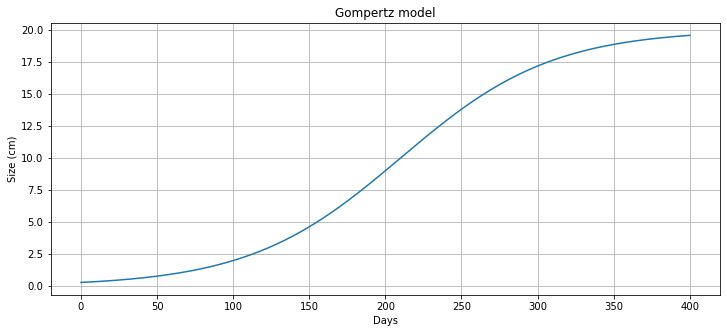

In [388]:
import pyomo.environ as pyo
import pyomo.dae as dae
import matplotlib.pyplot as plt
import numpy as np

rho = 0.02
K = 20.0

def growth_model(IC=1.0, tf=400):

    m = pyo.ConcreteModel()
    m.t = dae.ContinuousSet(bounds=(0, tf))

    m.N = pyo.Var(m.t, domain=pyo.NonNegativeReals)
    m.dNdt = dae.DerivativeVar(m.N)
    
    m.N[0].fix(IC)

    @m.Constraint(m.t)
    def gompertz(m, t):
        return m.dNdt[t] == rho * m.N[t] * (1 - m.N[t]/K)

    pyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=2*int(tf), scheme='FORWARD')
    pyo.SolverFactory('ipopt').solve(m)
    
    return m

m = growth_model(0.3, 400)

fig, *ax = plt.subplots(figsize=(12, 5))
ax[0].plot(m.t, [m.N[t]() for t in m.t], label='untreated growth')
ax[0].set_xlabel('Days')
ax[0].set_ylabel('Size (cm)')
ax[0].set_title('Gompertz model')
ax[0].grid(True)

## Problem 2. Radiation Therapy (10pts)

Radiation therapy is a widely use therapy intervention for many solid tumors. A model for the effect of radiation is given by

$$\frac{dN}{dt} = \underbrace{\rho N \left(1 - \frac{N}{K}\right)}_\text{Growth} - \underbrace{\left(\alpha d(t) + \beta d(t)^2\right)N}_\text{Radition}$$

where the second term modifies the Gompertz growth model to include radiation effects. ($\alpha = 0.06$, $\beta = 0.006$)

$$\alpha = 0.08$$
$$\beta = 0.008$$

Variable $d(t)$ is dosage measured in Gray (Gy), the standard SI units for absorbed dose of ionizing radiation. The radiation therapy is limited to a daily limit of 0.8 Gray/day and a total limit of 60 Gray.  As a head start, the following Pyomo model is given which incorporates the constraint

$$\int_0^{t_f} d(t)\ dt \leq 60$$

The main challenge of this problem is to identify and implement a meaningful objective function.

1. Modify the Pyomo model below to include the $d \leq 0.8$ Gy constraint on daily dose.

2. Consider a therapy horizon of 400 days. In either words or with a mathematical expression, write down an objective function in the cell below. 

3. Implement and test your objective function for a patient diagnosed with Stage 2 disease.  You may need to modify and test your objective until you arrive at a relevant result. There is no "right" answer, but some answers are better than others. Will radiation therapy alone provide adequate treatment subject the constraints and given model parameters?

Your solution will be graded as follows:

1. Written rationale for the choice of objective. (4 pts.)
2. Correctly implemented constraints on radiation. (2 pts.)
3. Code and implementation. (4 pts.)


59.59860467993624


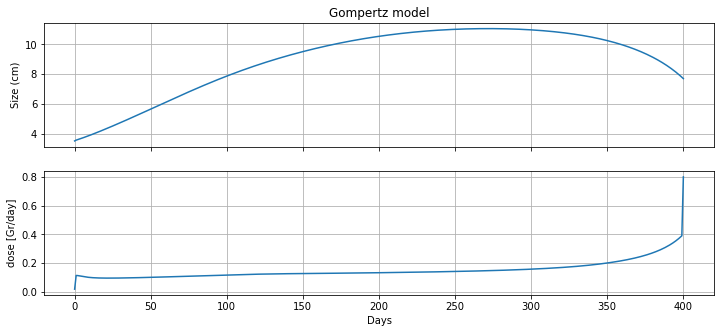

In [387]:
import pyomo.environ as pyo
import pyomo.dae as dae
import matplotlib.pyplot as plt
import numpy as np

alpha = 0.06
beta =  0.006

def radiation_model(IC=1.0, tf=400):

    m = pyo.ConcreteModel()
    m.t = dae.ContinuousSet(bounds=(0, tf))

    m.N = pyo.Var(m.t, domain=pyo.NonNegativeReals)
    m.d = pyo.Var(m.t, domain=pyo.NonNegativeReals)
    
    m.dNdt = dae.DerivativeVar(m.N)
    
    m.N[0].fix(IC)
    
    @m.Integral(m.t)
    def doseage(m, t):
        return m.d[t]
    
    @m.Constraint()
    def total_dose(m):
        return m.doseage <= 60

    @m.Constraint(m.t)
    def gompertz(m, t):
        return m.dNdt[t] == rho * m.N[t] * (1 - m.N[t]/K) - (alpha * m.d[t] + beta * m.d[t]**2) * m.N[t]

    pyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=1*int(tf), scheme='FORWARD')
    pyo.SolverFactory('ipopt').solve(m)
    
    return m

m = radiation_model(3.5, 400)

fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
ax[0].plot(m.t, [m.N[t]() for t in m.t], label='untreated growth')
ax[0].set_ylabel('Size (cm)')
ax[0].set_title('Gompertz model')
ax[0].grid(True)

ax[1].plot(m.t, [m.d[t]() for t in m.t], label='radiation')
ax[1].set_ylabel('dose [Gr/day]')
ax[1].set_xlabel('Days')
ax[1].grid(True)

print(m.doseage())

## Problem 3. Combined Radiation and Chemo Therapy (20 pts)

Another common treatment is a combination of chemotherapy and radiation. The chemotherapy is incorporated in the model as 

$$\frac{dN}{dt} = \underbrace{\rho N \left(1 - \frac{N}{K}\right)}_\text{Growth} - \underbrace{\left(\alpha d(t) + \beta d(t)^2\right)N}_\text{Radition} + \underbrace{-\gamma C(t) N}_\text{Chemotherapy}$$

where the parameter $\gamma = 0.01$. The chemotherapeutic agent is toxic and therefore limited to 4 units per day, and a total 100 units over 100 days. The drug as a half-life of 1 day.

1. Using the Pyomo model below as a starting point, add additional decision variables `m.u[t]` to model the administration of the chemotherapeutic agent, and `m.C[t]` to model the blood concentration of the agent. You will need to add an additional differential equation to model the half-life of the agent in the bloodstream.

2. Add constraints all necessary constraints to restrict the total radiation and chemotherapeutic dosages. 

3. Add a suitable objective functions.

4. Test the performance of your approach to a patient presenting with Stage 3 disease. 

Grading:

1. 


In [ ]:
import pyomo.environ as pyo
import pyomo.dae as dae
import matplotlib.pyplot as plt
import numpy as np

alpha = 0.06
beta =  0.006

def radiation_model(IC=1.0, tf=400):

    m = pyo.ConcreteModel()
    m.t = dae.ContinuousSet(bounds=(0, tf))

    m.N = pyo.Var(m.t, domain=pyo.NonNegativeReals)
    m.d = pyo.Var(m.t, domain=pyo.NonNegativeReals)
    
    m.dNdt = dae.DerivativeVar(m.N)
    
    m.N[0].fix(IC)
    
    @m.Integral(m.t)
    def doseage(m, t):
        return m.d[t]
    
    @m.Constraint()
    def total_dose(m):
        return m.doseage <= 60

    @m.Constraint(m.t)
    def gompertz(m, t):
        return m.dNdt[t] == rho * m.N[t] * (1 - m.N[t]/K) - (alpha * m.d[t] + beta * m.d[t]**2) * m.N[t]

    pyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=1*int(tf), scheme='FORWARD')
    pyo.SolverFactory('ipopt').solve(m)
    
    return m

m = radiation_model(3.5, 400)

fig, ax = plt.subplots(3, 1, figsize=(12, 5), sharex=True)
ax[0].plot(m.t, [m.N[t]() for t in m.t], label='untreated growth')
ax[0].set_ylabel('Size (cm)')
ax[0].set_title('Gompertz model')
ax[0].grid(True)

ax[1].plot(m.t, [m.d[t]() for t in m.t], label='radiation')
ax[1].set_ylabel('dose [Gr/day]')
ax[1].set_xlabel('Days')
ax[1].grid(True)

ax[2].plot(m.t, [m.u[t]() for t in m.t], label='chemotherapy')
ax[2].set_ylabel('dose [Gr/day]')
ax[2].set_xlabel('Days')
ax[2].grid(True)


print(m.doseage())

3. 


In [354]:
alpha = 0.16
dmax = 0.8
tf = 400

import pyomo.environ as pyo
import pyomo.dae as dae
import matplotlib.pyplot as plt

def growth_model():

    m = pyo.ConcreteModel()
    m.t = dae.ContinuousSet(bounds=(0, tf))

    m.N = pyo.Var(m.t, domain=pyo.NonNegativeReals)
    m.d = pyo.Var(m.t, domain=pyo.NonNegativeReals, bounds=(0, dmax))
    m.Nmax = pyo.Var()

    m.dNdt = dae.DerivativeVar(m.N)
    
    @m.Integral(m.t)
    def radiation(m, t):
        return m.d[t]
    
    @m.Constraint()
    def total_radition_limit(m):
        return m.radiation <= 60.0
    
    @m.Constraint(m.t)
    def negative_growth(m, t):
        return m.N[t] <= m.N[0]

    @m.Constraint(m.t)
    def gompertz(m, t):
        return m.dNdt[t] == rho * m.N[t] * pyo.log(K / m.N[t]) - (alpha * m.d[t] * m.N[t]

    m.N[0].fix(N_1)
    
    @m.Objective(sense=pyo.minimize)
    def objective(m):
        return m.N[tf]

    pyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=1000)
    pyo.SolverFactory('ipopt').solve(m)
    
    return m

m = growth_model()

fig, ax = plt.subplots(2, 1, figsize=(12, 5))
ax[0].plot(m.t, [m.N[t]() for t in m.t])
ax[1].plot(m.t, [m.d[t]() for t in m.t])

SyntaxError: invalid syntax (4211747485.py, line 36)

In [71]:
$$\frac{dC}{dt} = -0.693 * t

Half-life = 1 day.



SyntaxError: invalid syntax (346086088.py, line 1)

$$\frac{dN}{dt} = \rho N \log(K/N) - \beta_c C N - \left(\alpha d(t) + \beta d(t)^2\right)N$$

In [175]:
K = 30
rho = 0.007

# tumor stages

N_1 = 1.66
N_2 = 4.49
N_3 = 5.63
N_4 = 9.26

# death condition

N_t = 13.0

# remission

N_0 = 0.03